# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as pplt
import seaborn as seab
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

% matplotlib inline


In [2]:

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)


In [3]:
profile = pd.read_json('data/profile.json', orient='records', lines=True)


In [4]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Analyzing portfolio dataframe: 

In [5]:
print(f"size: {portfolio.size}")
print(f"shape: {portfolio.shape}")

size: 60
shape: (10, 6)


In [6]:
portfolio.head(20)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [7]:
mlb = MultiLabelBinarizer()
my_portfolio = portfolio.copy()
my_portfolio = my_portfolio.join(pd.DataFrame(mlb.fit_transform(my_portfolio.pop('channels')),
                          columns=mlb.classes_,
                          index=my_portfolio.index))

my_portfolio.head(20)

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


## Analyzing profile dataframe:

In [8]:
print(f"size: {profile.size}")
print(f"shape: {profile.shape}")

size: 85000
shape: (17000, 5)


In [9]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [10]:
print (f"Number of clients with no age informed: {profile[profile.age == 118].shape[0]}")
print (f"Number of clients with no gender informed: {profile[profile.gender.isna()].shape[0]}")
print (f"Number of clinets with no gender and age informed: {(profile[profile.gender.isna()])[profile.age == 118].shape[0]}")
print (f"Number of clients with no income informed: {profile[profile.income.isna()].shape[0]}")
print (f"Number of clients with no age+gender+income iformed: {((profile[profile.gender.isna()])[profile.income.isna()])[profile.age == 118].shape[0]}")

Number of clients with no age informed: 2175
Number of clients with no gender informed: 2175
Number of clinets with no gender and age informed: 2175
Number of clients with no income informed: 2175
Number of clients with no age+gender+income iformed: 2175


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


#### My first decission regarding data transformation will be to dispose those clients with missing age, income and gender. This will reduce the data set from 17000 to 14825 rows, which is still a big ammount of data.

In [11]:
my_profile = profile[profile.age < 118]
my_profile = my_profile.reset_index(drop=True)
my_profile.head()

,age,became_member_on,gender,id,income
0,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
1,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
2,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
3,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
4,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


I will now transform the 'became_member_on' field in a date format I can work with and analyze

In [12]:
my_profile.became_member_on = pd.to_datetime(my_profile.became_member_on, format = '%Y%m%d')
my_profile.head()

,age,became_member_on,gender,id,income
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
1,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
2,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
3,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
4,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


Analyzing the different features of the data set:

In [13]:
my_p_fem = my_profile[my_profile.gender == 'F']
my_p_mal = my_profile[my_profile.gender == 'M']

print (f"Number of female clients: {my_p_fem.shape[0]} ({my_p_fem.shape[0]/my_profile.shape[0]*100} %)")
print (f"Number of male clients: {my_p_mal.shape[0]} ({my_p_mal.shape[0]/my_profile.shape[0]*100} %)")


Number of female clients: 6129 (41.342327150084316 %)
Number of male clients: 8484 (57.227655986509276 %)


In [14]:
my_profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

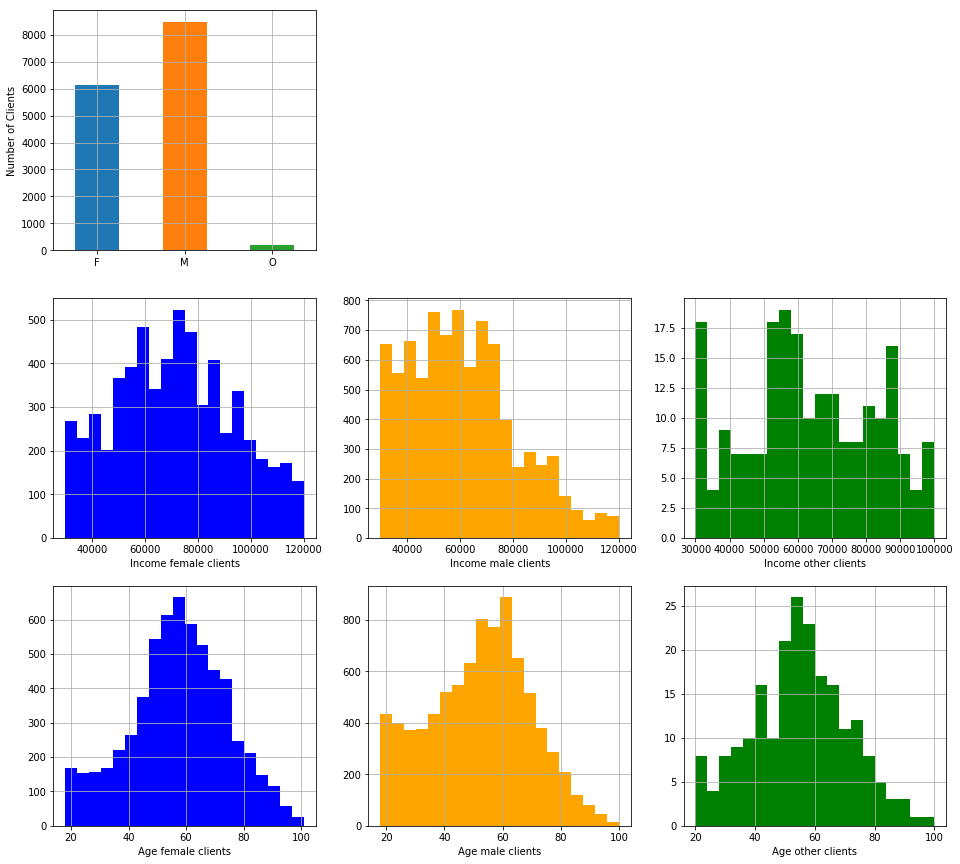

In [15]:
my_p_oth = my_profile[my_profile.gender == 'O']

pplt.figure(figsize=(16,15))

pplt.subplot(331)
my_profile.gender.value_counts().reindex(['F', 'M', 'O']).plot(kind='bar', rot=0)
pplt.ylabel('Number of Clients')
pplt.grid()

#print("\n")


#pplt.figure(figsize=(16,5))

pplt.subplot(334)
pplt.hist(my_p_fem.income, 20, color="blue")
pplt.xlabel('Income female clients')
pplt.grid()

pplt.subplot(335)
pplt.hist(my_p_mal.income, 20, color="orange")
pplt.xlabel('Income male clients')
pplt.grid()

pplt.subplot(336)
pplt.hist(my_p_oth.income, 20, color="green")
pplt.xlabel('Income other clients')
pplt.grid()

pplt.subplot(337)
pplt.hist(my_p_fem.age, 20, color="blue")
pplt.xlabel('Age female clients')
pplt.grid()

pplt.subplot(338)
pplt.hist(my_p_mal.age, 20, color="orange")
pplt.xlabel('Age male clients')
pplt.grid()

pplt.subplot(339)
pplt.hist(my_p_oth.age, 20, color="green")
pplt.xlabel('Age other clients')
pplt.grid()


The distribution of male and female population in the age and income features are very similar. The same with the "other" population and the income feature (the age feature distribution is a little bit different but probably because of the small amount of "other" population).

Remarkable different could be here that there are more male clients than female.

Analyzing the membership date:

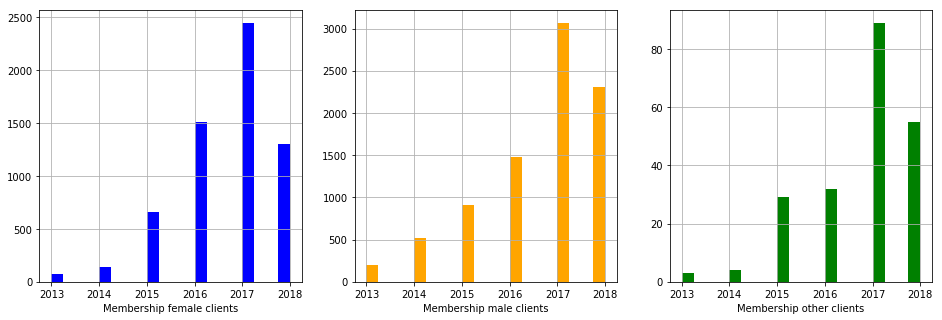

In [16]:
pplt.figure(figsize=(16,5))

pplt.subplot(131)
pplt.hist(my_p_fem.became_member_on.dt.year, 20, color="blue")
pplt.xlabel('Membership female clients')
pplt.grid()

pplt.subplot(132)
pplt.hist(my_p_mal.became_member_on.dt.year, 20, color="orange")
pplt.xlabel('Membership male clients')
pplt.grid()

pplt.subplot(133)
pplt.hist(my_p_oth.became_member_on.dt.year, 20, color="green")
pplt.xlabel('Membership other clients')
pplt.grid()

We can see that the distribution is more or less the same for male and female clients, except for the last year where the decrease of new memberships is considerably bigger for female clients.

## Analyzing transcript dataframe:

In [17]:
print(f"size: {transcript.size}")
print(f"shape: {transcript.shape}")

size: 1226136
shape: (306534, 4)


In [18]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [19]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

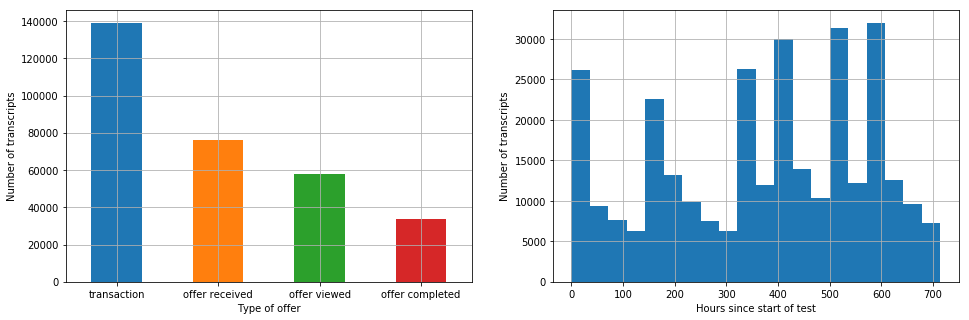

In [20]:

pplt.figure(figsize=(16,5))


pplt.subplot(121)
transcript.event.value_counts().plot(kind='bar', rot=0)
pplt.ylabel('Number of transcripts')
pplt.xlabel('Type of offer')
pplt.grid()


pplt.subplot(122)
pplt.hist(transcript.time, 20, color="tab:blue")
pplt.ylabel('Number of transcripts')
pplt.xlabel('Hours since start of test')
pplt.grid()



An interesting (at least for me) result of the analysis above is that less than the half of the offers received are completed.
It could be interesting to see if the ratio is different depending of the type of discount (bogo or discount).


#### Second decision: My deep learning exercise will be to predict if a client will complete a bogo or a discount offer.



Continuing transforming the data to ease its processing...

In [21]:
tr_tran=transcript[transcript.event == 'transaction']
tr_tran.head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [22]:
tr_rcvd=transcript[transcript.event == 'offer received']
tr_rcvd.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [23]:
tr_view=transcript[transcript.event == 'offer viewed']
tr_view.head()

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [24]:
tr_comp=transcript[transcript.event == 'offer completed']
tr_comp.head()

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


In [25]:
tr_comp.iloc[0].value

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

I will convert the 'value' dictionary into different columns to make the table easier to work with... and to be able to search for duplicates in the data.

In [26]:
for i in tr_tran.index:
    tr_tran.at[i,'amount'] = tr_tran.at[i,'value']['amount']

tr_tran.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,event,person,time,value,amount
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},0.83
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56},34.56
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23},13.23
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51},19.51
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97},18.97


In [27]:
for i in tr_rcvd.index:
    tr_rcvd.at[i,'offer_id'] = tr_rcvd.at[i,'value']['offer id']

tr_rcvd.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


In [28]:
for i in tr_view.index:
    tr_view.at[i,'offer_id'] = tr_view.at[i,'value']['offer id']

tr_view.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,event,person,time,value,offer_id
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837


In [29]:
for i in tr_comp.index:
    tr_comp.at[i,'offer_id'] = tr_comp.at[i,'value']['offer_id']
    tr_comp.at[i,'reward'] = tr_comp.at[i,'value']['reward']

tr_comp.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,event,person,time,value,offer_id,reward
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,2906b810c7d4411798c6938adc9daaa5,2.0
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd,10.0
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0


In [30]:
my_transcript = pd.concat([tr_tran, tr_rcvd, tr_view, tr_comp])
my_transcript = my_transcript[['event' , 'person' , 'time', 'amount', 'offer_id', 'reward' , 'value']]
my_transcript = my_transcript.reset_index(drop=True)
my_transcript.drop(columns=['value'] , inplace=True)
my_transcript.head()


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,event,person,time,amount,offer_id,reward
0,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN
1,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN
2,transaction,54890f68699049c2a04d415abc25e717,0,13.23,NaN,NaN
3,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,NaN
4,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,NaN


In [31]:
my_transcript[my_transcript.event == 'offer completed'].head()

,event,person,time,amount,offer_id,reward
272955,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
272956,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
272957,offer completed,629fc02d56414d91bca360decdfa9288,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
272958,offer completed,676506bad68e4161b9bbaffeb039626b,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0
272959,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0


I will now transform the columt event to a dummy/indicator variable, so I can work with its values more conveniently

In [32]:
my_transcript = pd.get_dummies(my_transcript , columns=['event'] , prefix='' ,prefix_sep='')
my_transcript.head()

,person,time,amount,offer_id,reward,offer completed,offer received,offer viewed,transaction
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN,0,0,0,1
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN,0,0,0,1
2,54890f68699049c2a04d415abc25e717,0,13.23,NaN,NaN,0,0,0,1
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,NaN,0,0,0,1
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,NaN,0,0,0,1


## Merging the three tables to have a data frame with the whole information available to work with

First I will merge transcript and profile tables (Actually the transformed version of them).

In [33]:
my_merge = pd.merge(my_transcript, my_profile, left_on='person', right_on='id', how='inner')
my_merge.drop(columns=['id'] , inplace=True)
my_merge.head()

,person,time,amount,offer_id,reward,offer completed,offer received,offer viewed,transaction,age,became_member_on,gender,income
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN,0,0,0,1,20,2016-07-11,F,30000.0
1,02c083884c7d45b39cc68e1314fec56c,6,1.44,NaN,NaN,0,0,0,1,20,2016-07-11,F,30000.0
2,02c083884c7d45b39cc68e1314fec56c,12,4.56,NaN,NaN,0,0,0,1,20,2016-07-11,F,30000.0
3,02c083884c7d45b39cc68e1314fec56c,84,1.53,NaN,NaN,0,0,0,1,20,2016-07-11,F,30000.0
4,02c083884c7d45b39cc68e1314fec56c,90,0.50,NaN,NaN,0,0,0,1,20,2016-07-11,F,30000.0


Now I will merge this with the portfolio table (with my transformed version).
P.S.: I will drop column reward from transcript table as this is redundant with the column reward from portfolio table

In [34]:
my_merge.drop(columns=['reward'], inplace=True)
my_merge = pd.merge(my_merge, my_portfolio , left_on='offer_id' , right_on='id'  ,how='left')
my_merge.drop(columns=['id'] , inplace=True)
my_merge.head()

,person,time,amount,offer_id,offer completed,offer received,offer viewed,transaction,age,became_member_on,gender,income,difficulty,duration,offer_type,reward,email,mobile,social,web
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,0,0,0,1,20,2016-07-11,F,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,02c083884c7d45b39cc68e1314fec56c,6,1.44,NaN,0,0,0,1,20,2016-07-11,F,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,02c083884c7d45b39cc68e1314fec56c,12,4.56,NaN,0,0,0,1,20,2016-07-11,F,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,02c083884c7d45b39cc68e1314fec56c,84,1.53,NaN,0,0,0,1,20,2016-07-11,F,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,02c083884c7d45b39cc68e1314fec56c,90,0.50,NaN,0,0,0,1,20,2016-07-11,F,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
my_merge.shape

(272762, 20)

## Preparing the data for the prediction model.

As already stated, I will try to predict if a client will take(complete) an offer (bogo or discount).
Therefore, I will take only those entries related to offers (that is, discard the transaction events and the informational offers)

In [36]:
my_merge_offer= my_merge[my_merge.transaction == 0]
my_merge_offer= my_merge_offer[my_merge_offer.offer_type != 'informational']
#my_merge_offer= my_merge_offer[my_merge_offer.gender != 'O']
my_merge_offer.head(10)

,person,time,amount,offer_id,offer completed,offer received,offer viewed,transaction,age,became_member_on,gender,income,difficulty,duration,offer_type,reward,email,mobile,social,web
10,02c083884c7d45b39cc68e1314fec56c,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,0,1,0,0,20,2016-07-11,F,30000.0,10.0,7.0,bogo,10.0,1.0,1.0,1.0,0.0
11,02c083884c7d45b39cc68e1314fec56c,408,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,20,2016-07-11,F,30000.0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
12,02c083884c7d45b39cc68e1314fec56c,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,0,0,1,0,20,2016-07-11,F,30000.0,10.0,7.0,bogo,10.0,1.0,1.0,1.0,0.0
25,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0,0,42,2016-01-17,M,96000.0,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
26,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,336,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,0,42,2016-01-17,M,96000.0,7.0,7.0,discount,3.0,1.0,1.0,1.0,1.0
27,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,408,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,42,2016-01-17,M,96000.0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
28,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,504,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0,42,2016-01-17,M,96000.0,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0
29,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,2906b810c7d4411798c6938adc9daaa5,0,0,1,0,42,2016-01-17,M,96000.0,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
30,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,342,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0,1,0,42,2016-01-17,M,96000.0,7.0,7.0,discount,3.0,1.0,1.0,1.0,1.0
31,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,462,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1,0,42,2016-01-17,M,96000.0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0


In [37]:
my_merge_offer.shape

(126145, 20)

As deciding features in the model data for my prediction machin I will choose: 'gender', 'age', 'income' and 'year_of_membership'.
The labels will be of two types: 'offer_bogo' and 'offer_discount'

In [38]:
model_data = my_merge_offer.groupby(['person' , 'offer_type']).agg({'offer completed':sum,
                                                                       'offer received': sum,
                                                                       'age':'last',
                                                                       'became_member_on':'last',
                                                                       'gender':'last',
                                                                       'income':'last'
                                                                       })
#model_data = model_data[my_model_data.offer_type != 'informational']
model_data = model_data.reset_index()
model_data.head(10)

,person,offer_type,offer completed,offer received,age,became_member_on,gender,income
0,0009655768c64bdeb2e877511632db8f,bogo,1,1,33,2017-04-21,M,72000.0
1,0009655768c64bdeb2e877511632db8f,discount,2,2,33,2017-04-21,M,72000.0
2,0011e0d4e6b944f998e987f904e8c1e5,bogo,1,1,40,2018-01-09,O,57000.0
3,0011e0d4e6b944f998e987f904e8c1e5,discount,2,2,40,2018-01-09,O,57000.0
4,0020c2b971eb4e9188eac86d93036a77,bogo,1,2,59,2016-03-04,F,90000.0
5,0020c2b971eb4e9188eac86d93036a77,discount,2,2,59,2016-03-04,F,90000.0
6,0020ccbbb6d84e358d3414a3ff76cffd,bogo,2,2,24,2016-11-11,F,60000.0
7,0020ccbbb6d84e358d3414a3ff76cffd,discount,1,1,24,2016-11-11,F,60000.0
8,003d66b6608740288d6cc97a6903f4f0,discount,3,3,26,2017-06-21,F,73000.0
9,00426fe3ffde4c6b9cb9ad6d077a13ea,discount,1,4,19,2016-08-09,F,65000.0


I will start transforming the colums and data inside the dataframe, so I'd rather work with a copy.

In [39]:
my_model_data = model_data.copy()
my_model_data = pd.get_dummies(my_model_data , columns=['gender'])
my_model_data['year_of_membership'] = my_model_data.became_member_on.dt.year
my_model_data.drop(columns=['became_member_on'] , inplace=True)
my_model_data.head(10)

,person,offer_type,offer completed,offer received,age,income,gender_F,gender_M,gender_O,year_of_membership
0,0009655768c64bdeb2e877511632db8f,bogo,1,1,33,72000.0,0,1,0,2017
1,0009655768c64bdeb2e877511632db8f,discount,2,2,33,72000.0,0,1,0,2017
2,0011e0d4e6b944f998e987f904e8c1e5,bogo,1,1,40,57000.0,0,0,1,2018
3,0011e0d4e6b944f998e987f904e8c1e5,discount,2,2,40,57000.0,0,0,1,2018
4,0020c2b971eb4e9188eac86d93036a77,bogo,1,2,59,90000.0,1,0,0,2016
5,0020c2b971eb4e9188eac86d93036a77,discount,2,2,59,90000.0,1,0,0,2016
6,0020ccbbb6d84e358d3414a3ff76cffd,bogo,2,2,24,60000.0,1,0,0,2016
7,0020ccbbb6d84e358d3414a3ff76cffd,discount,1,1,24,60000.0,1,0,0,2016
8,003d66b6608740288d6cc97a6903f4f0,discount,3,3,26,73000.0,1,0,0,2017
9,00426fe3ffde4c6b9cb9ad6d077a13ea,discount,1,4,19,65000.0,1,0,0,2016


Now, it is time to split the model data into two different: the one to predict if bogo offer will be taken and the one to predict if discount offer will be taken.
This is needed too because as the events are independent (to take a bogo offer and to take a discount offer), we shouldn't use the data that shows the behaviour towards a discount offer to train a machine learning prediction model about behaviour towards a bogo offer and vice-versa.

In [40]:
my_md_bogo = my_model_data[my_model_data.offer_type == 'bogo'].reset_index(drop=True)
my_md_disc = my_model_data[my_model_data.offer_type == 'discount'].reset_index(drop=True)

In [41]:
print(my_model_data.shape)
print(my_md_bogo.shape)
print(my_md_disc.shape)

(26124, 10)
(13082, 10)
(13042, 10)


In [42]:
def fill_taken (df):
    for i in df.index:
        if (df.at[i,'offer completed'] > (df.at[i,'offer received']*0.2)):
            df.at[i,'offer_taken'] = 1
        else:
            df.at[i,'offer_taken'] = 0
    return df

my_md_bogo = fill_taken(my_md_bogo)
my_md_disc = fill_taken(my_md_disc)


In [43]:
print (my_md_bogo.shape)
my_md_bogo.head(10)

(13082, 11)


,person,offer_type,offer completed,offer received,age,income,gender_F,gender_M,gender_O,year_of_membership,offer_taken
0,0009655768c64bdeb2e877511632db8f,bogo,1,1,33,72000.0,0,1,0,2017,1.0
1,0011e0d4e6b944f998e987f904e8c1e5,bogo,1,1,40,57000.0,0,0,1,2018,1.0
2,0020c2b971eb4e9188eac86d93036a77,bogo,1,2,59,90000.0,1,0,0,2016,1.0
3,0020ccbbb6d84e358d3414a3ff76cffd,bogo,2,2,24,60000.0,1,0,0,2016,1.0
4,004b041fbfe44859945daa2c7f79ee64,bogo,1,1,55,74000.0,1,0,0,2018,1.0
5,004c5799adbf42868b9cff0396190900,bogo,3,3,54,99000.0,0,1,0,2016,1.0
6,005500a7188546ff8a767329a2f7c76a,bogo,1,4,56,47000.0,0,1,0,2017,1.0
7,0056df74b63b4298809f0b375a304cf4,bogo,1,1,54,91000.0,0,1,0,2016,1.0
8,00715b6e55c3431cb56ff7307eb19675,bogo,2,2,58,119000.0,1,0,0,2017,1.0
9,0082fd87c18f45f2be70dbcbb0fb8aad,bogo,2,2,28,68000.0,1,0,0,2017,1.0


In [44]:
print (my_md_disc.shape)
my_md_disc.head(10)

(13042, 11)


,person,offer_type,offer completed,offer received,age,income,gender_F,gender_M,gender_O,year_of_membership,offer_taken
0,0009655768c64bdeb2e877511632db8f,discount,2,2,33,72000.0,0,1,0,2017,1.0
1,0011e0d4e6b944f998e987f904e8c1e5,discount,2,2,40,57000.0,0,0,1,2018,1.0
2,0020c2b971eb4e9188eac86d93036a77,discount,2,2,59,90000.0,1,0,0,2016,1.0
3,0020ccbbb6d84e358d3414a3ff76cffd,discount,1,1,24,60000.0,1,0,0,2016,1.0
4,003d66b6608740288d6cc97a6903f4f0,discount,3,3,26,73000.0,1,0,0,2017,1.0
5,00426fe3ffde4c6b9cb9ad6d077a13ea,discount,1,4,19,65000.0,1,0,0,2016,1.0
6,004b041fbfe44859945daa2c7f79ee64,discount,1,1,55,74000.0,1,0,0,2018,1.0
7,004c5799adbf42868b9cff0396190900,discount,2,2,54,99000.0,0,1,0,2016,1.0
8,005500a7188546ff8a767329a2f7c76a,discount,0,1,56,47000.0,0,1,0,2017,0.0
9,0056df74b63b4298809f0b375a304cf4,discount,2,2,54,91000.0,0,1,0,2016,1.0


Creating the final model data to feed my prediction model:

In [45]:
my_md_bogo = my_md_bogo[['age', 'income', 'gender_F', 'gender_M', 'gender_O', 'year_of_membership', 'offer_taken']]
my_md_disc = my_md_disc[['age', 'income', 'gender_F', 'gender_M', 'gender_O' , 'year_of_membership', 'offer_taken']]
ybogo = my_md_bogo.offer_taken
Xbogo = my_md_bogo.drop(columns=['offer_taken'])
ydisc = my_md_disc.offer_taken
Xdisc = my_md_disc.drop(columns=['offer_taken'])

In [46]:
Xbogo_train, Xbogo_test, ybogo_train, ybogo_test = train_test_split(Xbogo, ybogo, test_size=0.2, random_state=42)
Xdisc_train, Xdisc_test, ydisc_train, ydisc_test = train_test_split(Xdisc, ydisc, test_size=0.2, random_state=42)

## Using and comparing different prediction models.

I will use a couple of models and calculate accuracy scores in two ways:
  1. using the score method of the model library
  2. calculating myself the % of success, false positives and false negatives (with the developed "evaluate_model" fuction)
    
This will help to compare suitability of different prediction models.


In [122]:
def evaluate_model (mod, X_test, y_test):
    model_success = 0
    model_fail = 0
    model_false_positive = 0
    model_false_negative = 0
    
    model_total = X_test.shape[0]

    for i in range(model_total):
        pr = mod.predict(X_test[i:i+1])[0]
        val = y_test.values[i]
        if (pr == val):
            model_success += 1
        else:
            if (val == 0):
                model_false_positive += 1
            else:
                model_false_negative += 1
                
    model_fail = model_false_positive + model_false_negative
    
    print (f'Number of predictions: {model_total}')
    print (f'Number of successful predictions: {model_success} ({(model_success/model_total)*100} %)')
    print (f'Number of false positives: {model_false_positive} ({(model_false_positive/model_total)*100} %)')
    print (f'Number of false negatives: {model_false_negative} ({(model_false_negative/model_total)*100} %)')
    print (f'Number of failed predictions: {model_fail} ({(model_fail/model_total)*100} %)')
    
    return
                

### GaussianNB Model:

In [123]:
pred_model1_bogo = GaussianNB()
pred_model1_disc = GaussianNB()
pred_model1_bogo.fit(Xbogo_train, ybogo_train)
pred_model1_disc.fit(Xdisc_train, ydisc_train)


GaussianNB(priors=None)

In [124]:
print(f'Prediction of bogo offer taken: score = {pred_model1_bogo.score(Xbogo_test,ybogo_test)}')
print(f'Prediction of discount offer taken: score = {pred_model1_disc.score(Xdisc_test,ydisc_test)}')


Prediction of bogo offer taken: score = 0.7168513565150936
Prediction of discount offer taken: score = 0.741663472594864


In [125]:
print ('Success of prediction of bogo offer taken:')
print ('')
evaluate_model (pred_model1_bogo, Xbogo_test, ybogo_test)

Success of prediction of bogo offer taken:

Number of predictions: 2617
Number of successful predictions: 1876 (71.68513565150936 %)
Number of false positives: 485 (18.53267099732518 %)
Number of false negatives: 256 (9.782193351165457 %)
Number of failed predictions: 741 (28.314864348490637 %)


In [126]:
print ('Success of prediction of discount offer taken:')
print ('')
evaluate_model (pred_model1_disc, Xdisc_test, ydisc_test)

Success of prediction of discount offer taken:

Number of predictions: 2609
Number of successful predictions: 1935 (74.1663472594864 %)
Number of false positives: 542 (20.77424300498275 %)
Number of false negatives: 132 (5.0594097355308545 %)
Number of failed predictions: 674 (25.833652740513607 %)


### SVC Model:

In [127]:
pred_model2_bogo = SVC()
pred_model2_disc = SVC()
pred_model2_bogo.fit(Xbogo_train, ybogo_train)
pred_model2_disc.fit(Xdisc_train, ydisc_train)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [128]:
print(f'Prediction of bogo offer taken: score = {pred_model2_bogo.score(Xbogo_test,ybogo_test)}')
print(f'Prediction of discount offer taken: score = {pred_model2_disc.score(Xdisc_test,ydisc_test)}')


Prediction of bogo offer taken: score = 0.6927779900649599
Prediction of discount offer taken: score = 0.738213875047911


In [129]:
print ('Success of prediction of bogo offer taken:')
print ('')
evaluate_model (pred_model2_bogo, Xbogo_test, ybogo_test)

Success of prediction of bogo offer taken:

Number of predictions: 2617
Number of successful predictions: 1813 (69.27779900649598 %)
Number of false positives: 574 (21.9335116545663 %)
Number of false negatives: 230 (8.788689338937715 %)
Number of failed predictions: 804 (30.72220099350401 %)


In [130]:
print ('Success of prediction of discount offer taken:')
print ('')
evaluate_model (pred_model2_disc, Xdisc_test, ydisc_test)

Success of prediction of discount offer taken:

Number of predictions: 2609
Number of successful predictions: 1926 (73.8213875047911 %)
Number of false positives: 585 (22.42238405519356 %)
Number of false negatives: 98 (3.7562284400153314 %)
Number of failed predictions: 683 (26.178612495208892 %)
